In [1]:
# !pip install 'qiskit[visualization]'
# !pip install qiskit_aer
# !pip install qiskit_ibm_runtime

In [2]:
import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_distribution
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.classical import expr
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_bloch_vector
from qiskit.visualization.bloch import Bloch
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
import qiskit_aer
import math
import numpy as np
import matplotlib.pyplot as plt
import random

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, 
                              pauli_error, depolarizing_error, thermal_relaxation_error)

### BB84 protocol

BB84, proposed by Bennett and Brassard in 1984. 
It uses quantum states to securely distribute cryptographic keys between two parties (Alice and Bob) 
by leveraging the no-cloning theorem (Eve cannot copy Alice's qubit) and
the uncertainty principle (Eve's measurement may affect Bob's measured value).

1. Quantum State Preparation (Alice):
   - For each bit of the key, Alice:
      - Randomly chooses a classical bit $a_i$ for encoded value
      - Randomly chooses a classical bit $b_i$ for z-basis (computational $|0\rangle$ or $|1\rangle$) or x-basis (Hadamard $|+\rangle$ or $|-\rangle$)
      - Prepares and sends quantum state according to:
      
         |$a_i$ | $b_i$ | $\vert \psi_{a_i b_i} \rangle$ |
         |------|-------|--------------------------------|
         |0     | 0     | $\vert 0 \rangle$              |
         |1     | 0     | $\vert 1 \rangle$              |
         |0     | 1     | $\vert + \rangle$              |
         |1     | 1     | $\vert - \rangle$              |

2. Quantum Measurement (Bob):
   - For each received qubit, Bob:
     a. Randomly chooses measurement basis z or x
     b. Measures the qubit in chosen basis
     c. Records measurement result

3. Public Discussion:
   - Alice and Bob publicly announce their basis choices
   - They keep only the bits where they used the same bases
   - Approximately 50% of bits are discarded

Implement send and receive $|\psi_{a_i b_i}\rangle$

In [3]:
def send_psiab(qc, a, b, c_a, c_b, psiab):
    """
    Prepares and sends a quantum state |\psi_ab> based on random classical bits generated from qubits a and b.
    
    This function implements the sender's part of a quantum protocol where:
    1. Two qubits (a and b) are initialized to |0> and transformed to |+> state using Hadamard gates
    2. Measuring these qubits generates random classical bits c_a and c_b
    3. Based on these classical bits, a quantum state |\psi_ab> is prepared according to the following mapping:
    
    c_a | c_b | |\psi_ab>
    -------------------
    0   | 0   | |0>
    1   | 0   | |1>
    0   | 1   | |+>
    1   | 1   | |->

    Parameters:
    -----------
    qc : QuantumCircuit
        The quantum circuit to add the operations to
    a : QuantumRegister
        First qubit used to generate random classical bit c_a
    b : QuantumRegister
        Second qubit used to generate random classical bit c_b
    c_a : ClassicalRegister
        Classical register to store the measurement result of qubit a
    c_b : ClassicalRegister
        Classical register to store the measurement result of qubit b
    psiab : QuantumRegister
        The qubit that will be prepared in state |\psi_ab⟩

    Returns:
    --------
    None
        The function modifies the quantum circuit in place
    """
    qc.initialize([1, 0], a)
    qc.initialize([1, 0], b)
    qc.h(a)
    qc.h(b)
    qc.measure(a, c_a)
    qc.measure(b, c_b)
    qc.initialize([1, 0], psiab)
    with qc.if_test((c_a, 1)) as else_:
        # a = 1
        qc.x(psiab)    
    with qc.if_test((c_b, 1)) as else_:
        # b = 1
        qc.h(psiab)

def receive_psiab(qc, psiab, b1, c_b1, c_a1):
    """
    qubit b1 is prepared to generate a random classical c_b bit.
    if c_b==0, measure along z.  if c_b==1, measure along x.
    measured result in c_a1.

    Implements the receiver's part of the quantum protocol by measuring the received quantum state |\psi_ab>
    in either Z or X base.

    This function:
    1. Generates a random bit c_b1 using a qubit b1 initialized to |+⟩ state
    2. Based on c_b1, measures the received state |\psi_ab> in different bases:
       - If c_b1 = 0: Measures in Z
       - If c_b1 = 1: Measures in X by applying H gate before and after measurement
    3. Stores the measurement result in classical bit c_a1

    Measurement Basis:
    ----------------
    c_b1 | Basis
    ---------------
    0    | Z-basis (computational basis |0>/|1>)
    1    | X-basis (Hadamard basis |+>/|->)

    Parameters:
    -----------
    qc : QuantumCircuit
        The quantum circuit to add the operations to
    psiab : QuantumRegister
        The received quantum state to be measured
    b1 : QuantumRegister
        Qubit used to generate random classical bit for deciding z or x basis
    c_b1 : ClassicalRegister
        Classical register to store the basis choice (0 for Z-basis, 1 for X-basis)
    c_a1 : ClassicalRegister
        Classical register to store the measurement result

    Returns:
    --------
    None
        The function modifies the quantum circuit in place
    """
    qc.initialize([1, 0], b1)
    qc.h(b1)
    qc.measure(b1, c_b1)
    with qc.if_test((c_b1, 1)) as else_:
        # measure along x
        qc.h(psiab)
        qc.measure(psiab, c_a1)
        qc.h(psiab)
    with else_: 
        qc.measure(psiab, c_a1)


Illustrate quantum circuit with Alice sending 2 qubits to Bob, N=2.

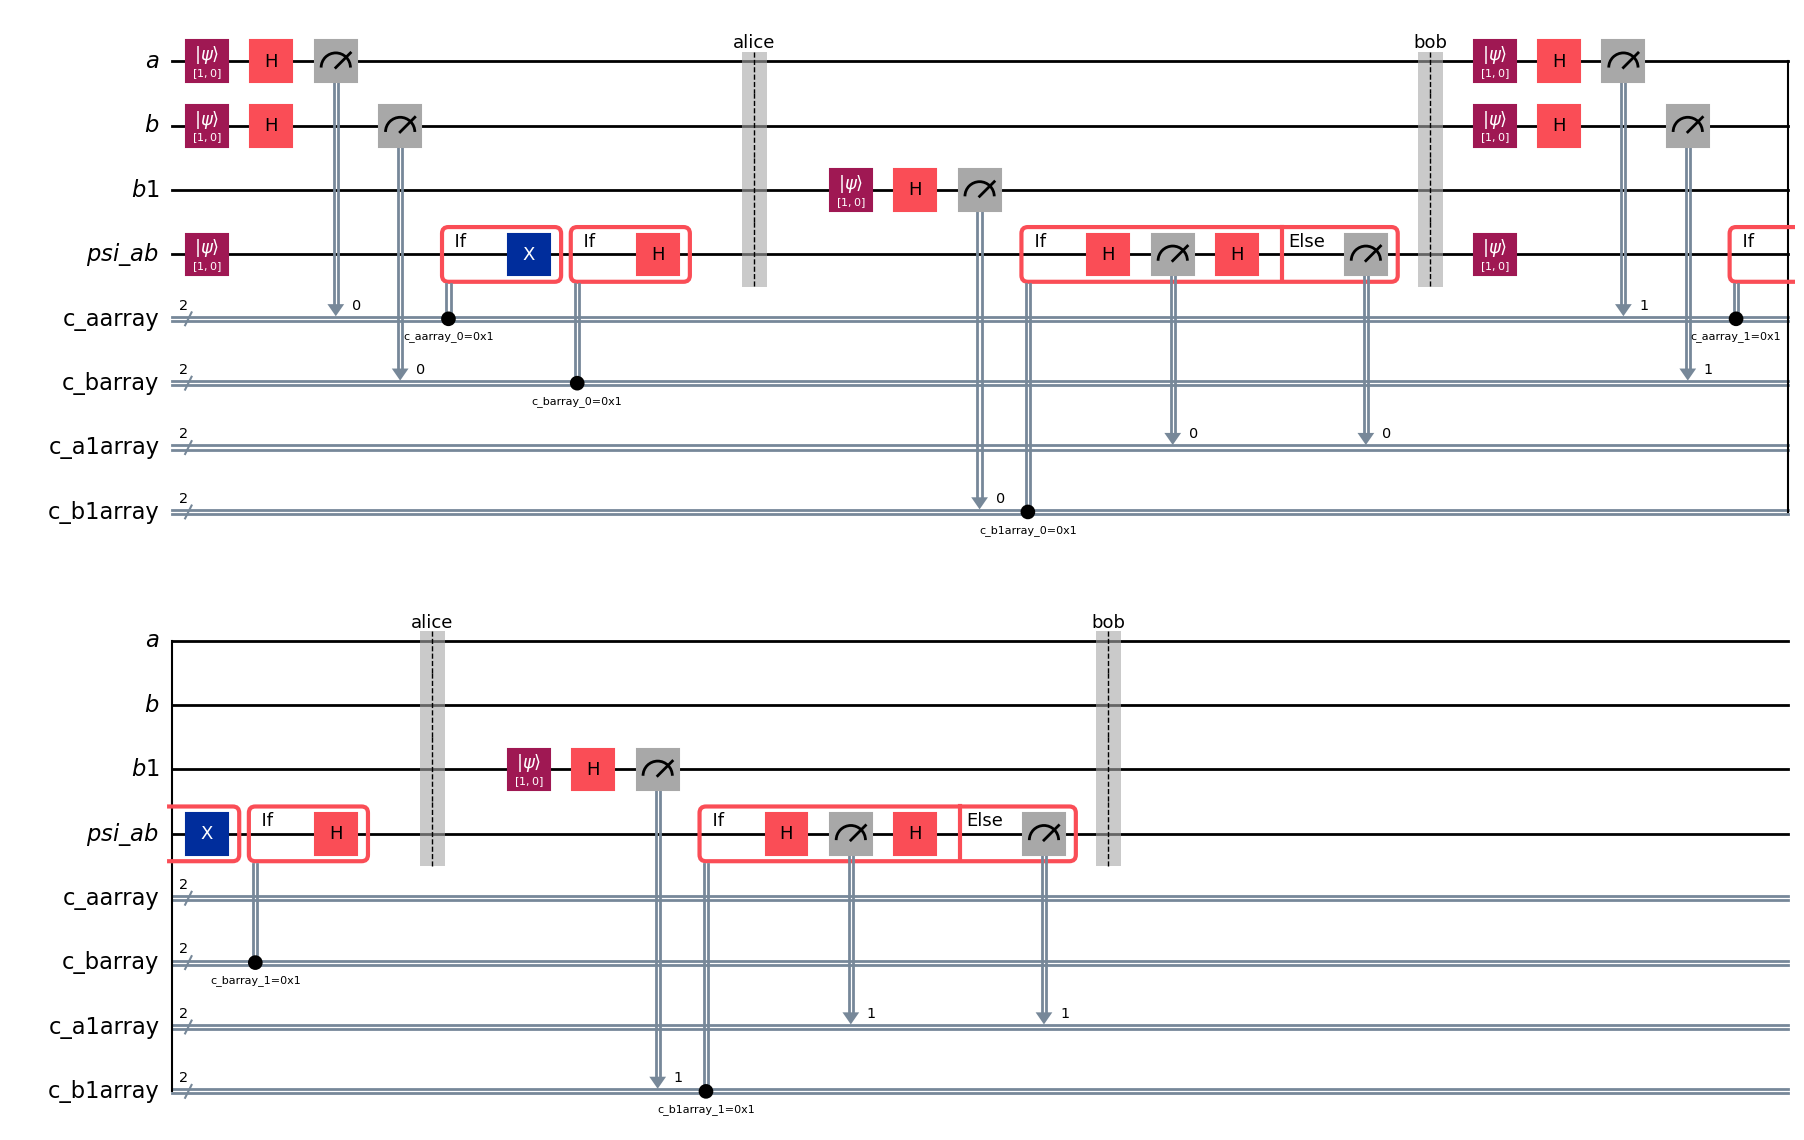

In [4]:
N = 2
areg = QuantumRegister(1, 'a')
breg = QuantumRegister(1, 'b')
b1reg = QuantumRegister(1, 'b1')
psiabreg = QuantumRegister(1, 'psi_ab')
c_aarrayreg = ClassicalRegister(N, 'c_aarray')
c_barrayreg = ClassicalRegister(N, 'c_barray')
c_a1arrayreg = ClassicalRegister(N, 'c_a1array')
c_b1arrayreg = ClassicalRegister(N, 'c_b1array')
qc = QuantumCircuit(areg, breg, b1reg, psiabreg, 
                    c_aarrayreg, c_barrayreg, c_a1arrayreg, c_b1arrayreg)
for i in range(N):
    send_psiab(qc, areg, breg, c_aarrayreg[i], c_barrayreg[i], psiabreg)
    qc.barrier(label='alice')
    # eavesdrop_psiab(qc, psiabreg, c_eve, 1)
    receive_psiab(qc, psiabreg, b1reg, c_b1arrayreg[i], c_a1arrayreg[i])
    qc.barrier(label='bob')
qc.draw('mpl')

Prepare circuit for Alice sending N qubits to Bob.  Alice's encoded values and Bob's decoded values are stored in N bits ClassicalRegister.

In [5]:
N = 200
areg = QuantumRegister(1, 'a')
breg = QuantumRegister(1, 'b')
b1reg = QuantumRegister(1, 'b1')
psiabreg = QuantumRegister(1, 'psi_ab')
c_aarrayreg = ClassicalRegister(N, 'c_aarray')
c_barrayreg = ClassicalRegister(N, 'c_barray')
c_a1arrayreg = ClassicalRegister(N, 'c_a1array')
c_b1arrayreg = ClassicalRegister(N, 'c_b1array')
# c_eve = ClassicalRegister(1, 'c_eve')
qc = QuantumCircuit(areg, breg, b1reg, psiabreg, 
                    c_aarrayreg, c_barrayreg, c_a1arrayreg, c_b1arrayreg)
for i in range(N):
    send_psiab(qc, areg, breg, c_aarrayreg[i], c_barrayreg[i], psiabreg)
    qc.barrier(label='alice')
    receive_psiab(qc, psiabreg, b1reg, c_b1arrayreg[i], c_a1arrayreg[i])
    qc.barrier(label='bob')
# qc.draw('mpl')    # circuit is too long to draw

Execute the circuit.

In [6]:
sampler = Sampler(mode=AerSimulator())
job = sampler.run([qc], shots=1)
result = job.result()[0]
samp_a = result.data.c_aarray.get_counts()
samp_b = result.data.c_barray.get_counts()
samp_a1 = result.data.c_a1array.get_counts()
samp_b1 = result.data.c_b1array.get_counts()
print(samp_a, samp_b)
print(samp_a1, samp_b1)


{'10101010000110111111110010100000010011011011111110101101100101010101100101001011001010100011110100011010101010010010010000110100001111101110101100101010110010100111011000000111110110011100101111011101': 1} {'10101001101010100001110000111110100110110100101010001001011001101000010111000110101111110011111011111100001000010100110000101000010011100110000011010011001101111001010000000000100010000010110110110110': 1}
{'11101011001000101011010110100000000101011111101100101111100101010111101110011001000110001001110110011010111000010011110100000101001111001110110100111011000011100011010000000110011010011100100111110111': 1} {'11000000010100010111000111111010111001110000110001011011011001001010011100010000100001011101110001001100110011010011011101011101010001001110111111100110110110011101011110111001001110101010111110001000': 1}


Compare Alice and Bob's basis and get the shared key.

In [7]:
def calc_mismatch_rate(s1, s2):
    mismatch_count = 0
    for i in range(len(s1)):
        if s1[i] != s2[i]:
            mismatch_count += 1
    return mismatch_count / len(s1)

In [8]:
# reverse string to turn qiskit bit 0 (rightmost bit) to *_array[0]
aarray = list(samp_a.keys())[0][::-1]
barray = list(samp_b.keys())[0][::-1]
a1array = list(samp_a1.keys())[0][::-1]
b1array = list(samp_b1.keys())[0][::-1]
alice_key = []
bob_key = []
for i in range(len(aarray)):
    if barray[i] == b1array[i]:     # compare alice's and bob's basis
        alice_key.append(aarray[i])
        bob_key.append(a1array[i])

print("key length: ", len(alice_key))
print("Alice's key: ", alice_key)
print("Bob's key  : ", bob_key)

mismatch_rate = calc_mismatch_rate(alice_key, bob_key)
if mismatch_rate == 0:
    print("key match: True")
else:
    print("key mismatch rate: ", mismatch_rate)

key length:  98
Alice's key:  ['1', '1', '1', '1', '0', '1', '0', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '0', '1', '1', '0', '0', '0', '1', '1', '0', '0', '0', '1', '1', '0', '1', '1', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '1', '0', '1', '1', '1', '1', '0', '0', '0', '0', '1', '1', '0', '1', '0', '1', '1', '1', '0', '1', '1', '0', '1', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0', '1']
Bob's key  :  ['1', '1', '1', '1', '0', '1', '0', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '0', '1', '1', '0', '0', '0', '1', '1', '0', '0', '0', '1', '1', '0', '1', '1', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '1', '0', '1', '1', '1', '1', '0', '0', '0', '0', '1', '1', '0', '1', '0', '1', '1', '1', '0', '1', '1', '0', '1', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1',

### Eavesdropping

If Eve eavesdrops (or measures) $|\psi_{a_i b_i}\rangle$ before Bob, the possible cases are,

1. Eve's measure basis is the same as Alice's or Bob's.  If it happened for all qubits, nobody will notice the eavesdropping.
2. Eve's measure basis is different from Alice's and Bob's while Alice and Bob use same basis.  Qubit state is alternated.  If Bob measures with same basis as Alice, there are 0.5 possibility to get different value from Alice.

Assume Eve eavesdrops every qubits.  If Alice and Bob choose the same basis, there is 0.5 chance Eve use different basis and then 0.5 chance Bob measures different value from Alice.  That is 0.25 of key mismatch between Alice and Bob.

In [9]:
def eavesdrop_psiab(qc, psiab, c_eve, eve_rate):
    """
    Implements a probabilistic eavesdropping strategy on the quantum channel with a specified
    intervention rate. This version of the eavesdropper measures in the computational (Z) basis
    with a certain probability.

    This function simulates Eve's intervention in the quantum protocol by:
    1. Probabilistically deciding whether to intercept based on eve_rate
    2. When intercepting, measuring in the computational (Z) basis to c_eve

    Parameters:
    -----------
    qc : QuantumCircuit
        The quantum circuit to add the operations to
    psiab : QuantumRegister
        The quantum state that may be intercepted and measured
    c_eve : ClassicalRegister
        Classical register to store the eavesdropping measured value 
    eve_rate : float
        Probability of Eve intercepting and measuring the quantum state (0.0 to 1.0)

    Returns:
    --------
    None
        The function modifies the quantum circuit in place

    Notes:
    ------
    - This implementation uses a simpler strategy than the basis-choosing version,
      always measuring in the computational basis when intervening
    - The probabilistic nature allows for studying the relationship between
      eavesdropping rate and error detection in the quantum key distribution protocol
    - Even partial eavesdropping (eve_rate < 1.0) can be detected during the
      reconciliation phase due to the quantum nature of the protocol
    """
    if c_eve is not None:
        if random.random() < eve_rate:
            qc.measure(psiab, c_eve)

Illustrate quantum circuit with Alice sending 2 qubits to Bob, N=2 and Eve always eavesdrops.

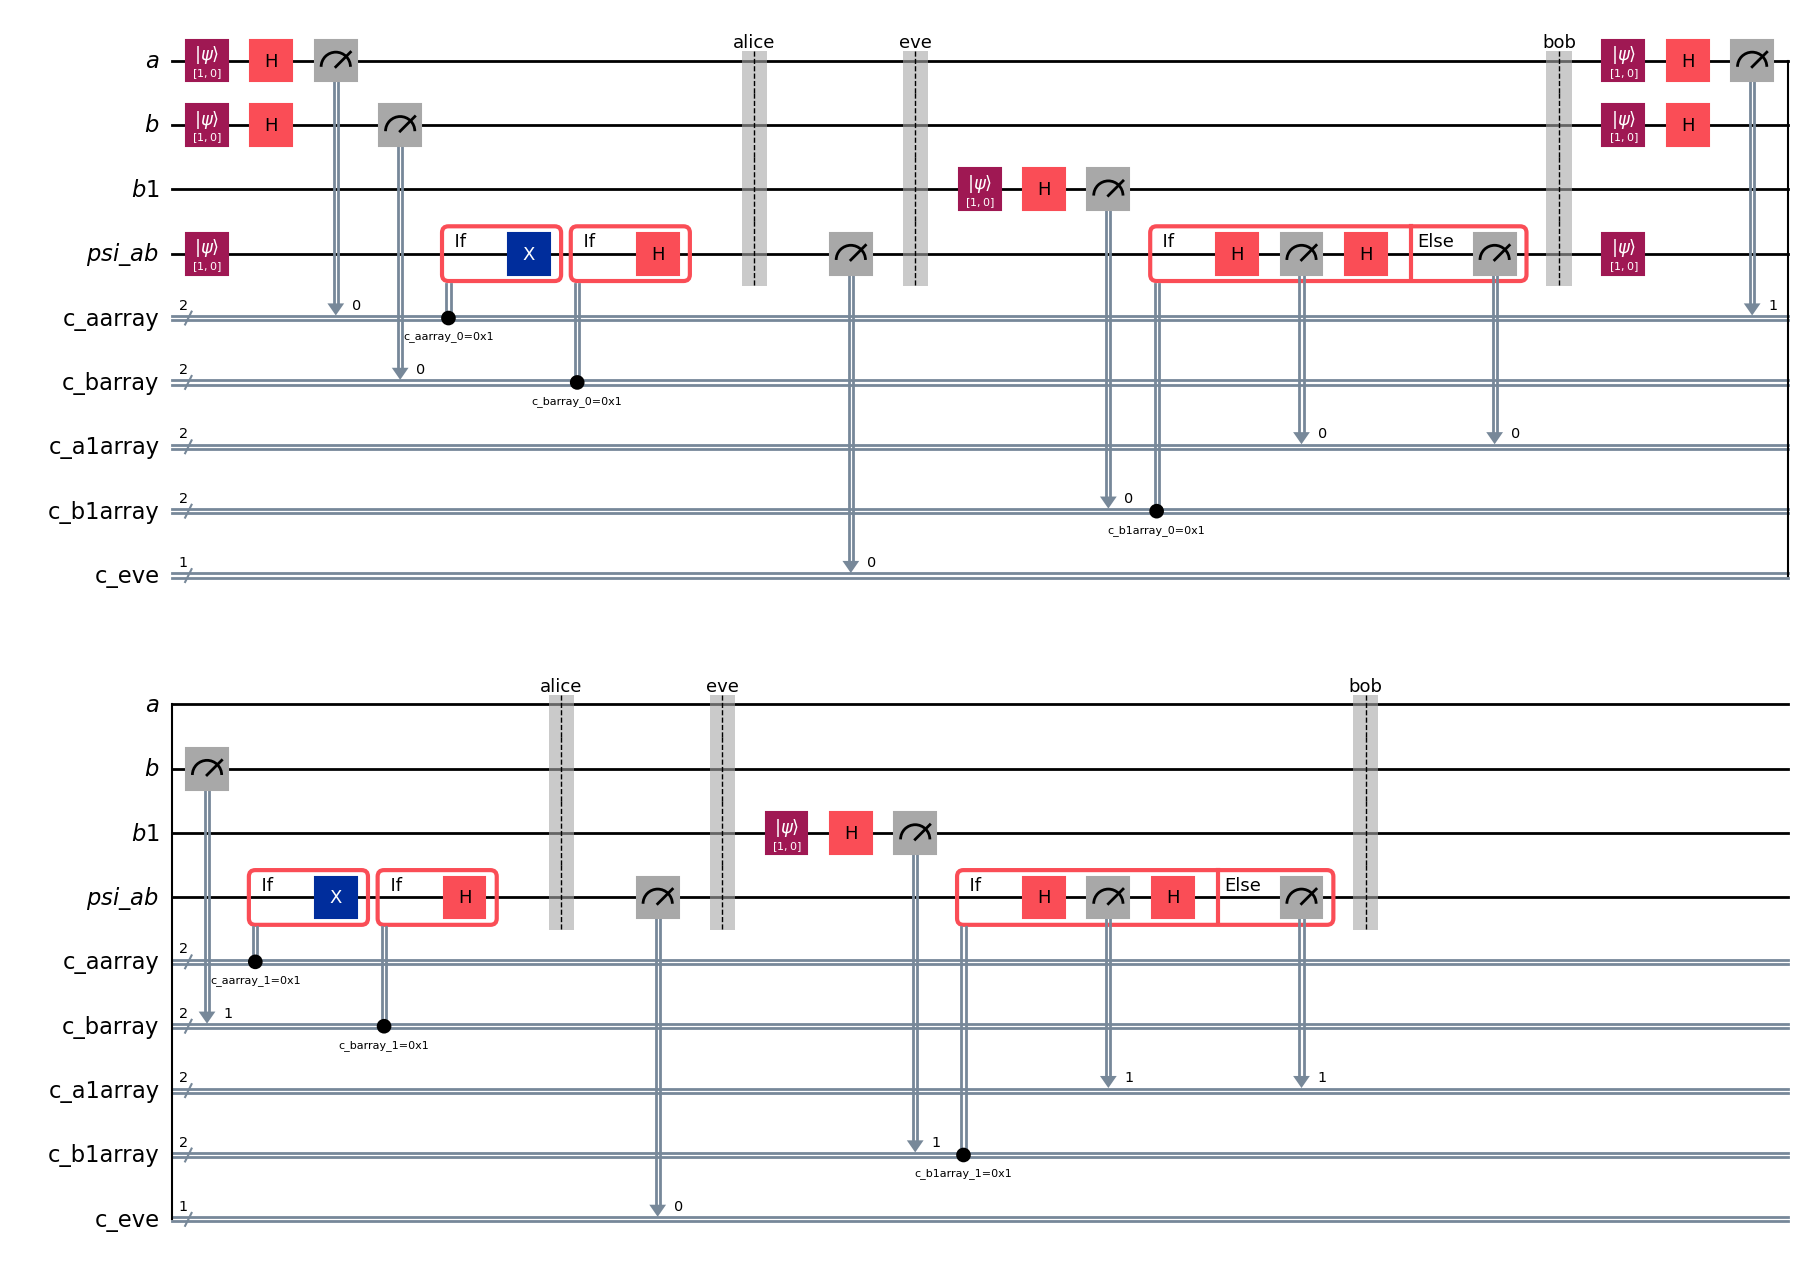

In [10]:
N = 2
areg = QuantumRegister(1, 'a')
breg = QuantumRegister(1, 'b')
b1reg = QuantumRegister(1, 'b1')
psiabreg = QuantumRegister(1, 'psi_ab')
c_aarrayreg = ClassicalRegister(N, 'c_aarray')
c_barrayreg = ClassicalRegister(N, 'c_barray')
c_a1arrayreg = ClassicalRegister(N, 'c_a1array')
c_b1arrayreg = ClassicalRegister(N, 'c_b1array')
c_eve = ClassicalRegister(1, 'c_eve')
qc = QuantumCircuit(areg, breg, b1reg, psiabreg, 
                    c_aarrayreg, c_barrayreg, c_a1arrayreg, c_b1arrayreg, c_eve)
for i in range(N):
    send_psiab(qc, areg, breg, c_aarrayreg[i], c_barrayreg[i], psiabreg)
    qc.barrier(label='alice')
    eavesdrop_psiab(qc, psiabreg, c_eve, 1)
    qc.barrier(label='eve')
    receive_psiab(qc, psiabreg, b1reg, c_b1arrayreg[i], c_a1arrayreg[i])
    qc.barrier(label='bob')
qc.draw('mpl')

Observe the key mismatch rate vs eavesdropping rate.

In [11]:
N = 200
areg = QuantumRegister(1, 'a')
breg = QuantumRegister(1, 'b')
b1reg = QuantumRegister(1, 'b1')
psiabreg = QuantumRegister(1, 'psi_ab')
c_aarrayreg = ClassicalRegister(N, 'c_aarray')
c_barrayreg = ClassicalRegister(N, 'c_barray')
c_a1arrayreg = ClassicalRegister(N, 'c_a1array')
c_b1arrayreg = ClassicalRegister(N, 'c_b1array')
c_eve = ClassicalRegister(1, 'c_eve')
ab_array = []
eavesdrop_rates = np.arange(0, 1.05, 0.05)
key_mismatch_rates = []
for r in eavesdrop_rates:
    qc = QuantumCircuit(areg, breg, b1reg, psiabreg,
                        c_aarrayreg, c_barrayreg, c_a1arrayreg, c_b1arrayreg, c_eve)
    for i in range(N):
        send_psiab(qc, areg, breg, c_aarrayreg[i], c_barrayreg[i], psiabreg)
        qc.barrier(label='alice')
        eavesdrop_psiab(qc, psiabreg, c_eve, r)
        qc.barrier(label='eve')
        receive_psiab(qc, psiabreg, b1reg, c_b1arrayreg[i], c_a1arrayreg[i])
        qc.barrier(label='bob')
    sampler = Sampler(mode=AerSimulator())
    job = sampler.run([qc], shots=1)
    result = job.result()[0]
    samp_a = result.data.c_aarray.get_counts()
    samp_b = result.data.c_barray.get_counts()
    samp_a1 = result.data.c_a1array.get_counts()
    samp_b1 = result.data.c_b1array.get_counts()

    # reverse string to turn qiskit bit 0 (rightmost bit) to *_array[0]
    aarray = list(samp_a.keys())[0][::-1]
    barray = list(samp_b.keys())[0][::-1]
    a1array = list(samp_a1.keys())[0][::-1]
    b1array = list(samp_b1.keys())[0][::-1]

    alice_key = []
    bob_key = []
    for i in range(len(aarray)):    
        if barray[i] == b1array[i]:     # compare alice's and bob's basis
            alice_key.append(aarray[i])
            bob_key.append(a1array[i])

    key_mismatch_rates.append(calc_mismatch_rate(alice_key, bob_key))

print(eavesdrop_rates)
print(key_mismatch_rates)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
[0.0, 0.028846153846153848, 0.03636363636363636, 0.0, 0.0392156862745098, 0.07920792079207921, 0.045454545454545456, 0.10309278350515463, 0.1, 0.11764705882352941, 0.15454545454545454, 0.13392857142857142, 0.12643678160919541, 0.1702127659574468, 0.2391304347826087, 0.23148148148148148, 0.22, 0.1414141414141414, 0.23809523809523808, 0.26881720430107525, 0.2727272727272727]


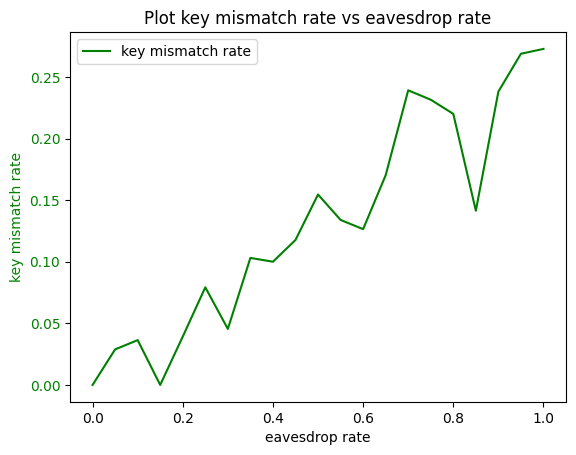

In [12]:
fig, ax1 = plt.subplots()

# Plot key mismatch rate against eavesdrop rate on the right axis
ax1.plot(eavesdrop_rates, key_mismatch_rates, label='key mismatch rate', color='green')
ax1.set_xlabel('eavesdrop rate')  # x-axis label
ax1.set_ylabel('key mismatch rate', color='green')  # y1-axis label on the left
ax1.tick_params(axis='y', labelcolor='green')  # Set color for the left y-axis ticks
ax1.legend()

# Add a title
plt.title('Plot key mismatch rate vs eavesdrop rate')

# Display the plot
plt.show()

### Noisy communication and key reconciliation

Even though there is no eavesdropping, Bob may not get the same key as Alice due to noisy quantum communication. 

Create a noisy simulator.

Aassume some error rate for reset qubit, measure qubit and single qubit operation (and hence 2-qubit operation).

In [13]:
# Example error probabilities
p_reset = 0.01
p_meas = 0.01
p_gatex = 0.01
p_gatez = 0.01

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gatex = pauli_error([('X',p_gatex), ('I', 1 - p_gatex)])
error_gatez = pauli_error([('Z', p_gatez), ('I', 1 - p_gatez)])
error_gate1 = error_gatex.compose(error_gatez)
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_xz = NoiseModel()
noise_xz.add_all_qubit_quantum_error(error_reset, "reset")
noise_xz.add_all_qubit_quantum_error(error_meas, "measure")
noise_xz.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_xz.add_all_qubit_quantum_error(error_gate2, ["cx"])

# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_xz)

For example, ```error_gatex``` means 0.01 probability to flip (apply X gate) a qubit 
(i.e. 0.99 probability to keep unchanged (apply I gate)).

In [14]:
print(error_gatex)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.01, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.99, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


```error_gate1``` is a combination of (0.01 probability X, 0.99 probability I) and (0.01 probability Z, 0.99 probability of I).

In [15]:
print(error_gate1)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0001, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ Z ├
   └───┘└───┘
  P(1) = 0.0099, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ I ├
   └───┘└───┘
  P(2) = 0.0099, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ Z ├
   └───┘└───┘
  P(3) = 0.9801, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ I ├
   └───┘└───┘


Run BB84 protocol with noisy simulator

In [16]:
N = 200
areg = QuantumRegister(1, 'a')
breg = QuantumRegister(1, 'b')
b1reg = QuantumRegister(1, 'b1')
psiabreg = QuantumRegister(1, 'psi_ab')
c_aarrayreg = ClassicalRegister(N, 'c_aarray')
c_barrayreg = ClassicalRegister(N, 'c_barray')
c_a1arrayreg = ClassicalRegister(N, 'c_a1array')
c_b1arrayreg = ClassicalRegister(N, 'c_b1array')
# c_psiabreg = ClassicalRegister(1, 'c_psi_ab')
c_eve = ClassicalRegister(1, 'c_eve')
ab_array = []
qc = QuantumCircuit(areg, breg, b1reg, psiabreg, 
                    c_aarrayreg, c_barrayreg, c_a1arrayreg, c_b1arrayreg, c_eve)
for i in range(N):
    send_psiab(qc, areg, breg, c_aarrayreg[i], c_barrayreg[i], psiabreg)
    eavesdrop_psiab(qc, psiabreg, c_eve, 0)
    receive_psiab(qc, psiabreg, b1reg, c_b1arrayreg[i], c_a1arrayreg[i])
# qc.draw('mpl')

In [17]:
# Transpile circuit for noisy basis gates
qc_t = transpile(qc, sim_noise)

noisy_sampler = Sampler(mode=sim_noise)
job = noisy_sampler.run([qc_t], shots=1)

result = job.result()[0]
samp_a = result.data.c_aarray.get_counts()
samp_b = result.data.c_barray.get_counts()
samp_a1 = result.data.c_a1array.get_counts()
samp_b1 = result.data.c_b1array.get_counts()
print(samp_a, samp_b)
print(samp_a1, samp_b1)

{'11000011100010000100000110111010101010011101000010110110111100110001101100011001011001111100100110011100000010111111000111100101101100010011001000100111011111111011010000100000101101000111011000111001': 1} {'00010000100100000100111111111001001010001000111011010100010000110100010100110100011001100101010110010011011100111100001011011010110100100110110000001010110010001111110001110011110011101001010010000001': 1}
{'11011011100000100100001001111000000000011001000011110100011100110011100101011001011000111000100110011110000010001001001111010101100010000011001011101111101111101011011100100100011001000111011101111001': 1} {'00001011000010100110110000111011110000001100110001110010101001101010111101101100010000110001110110011001101111001010000000101011111010010011110011100110001111111111111100101101001110000101010111100100': 1}


Probably will get a non-zero share key mismatch rate.  If not, try to rerun the circuit.

In [18]:
# reverse string to turn qiskit bit 0 (rightmost bit) to *_array[0]
aarray = list(samp_a.keys())[0][::-1]
barray = list(samp_b.keys())[0][::-1]
a1array = list(samp_a1.keys())[0][::-1]
b1array = list(samp_b1.keys())[0][::-1]
alice_key = []
bob_key = []
for i in range(len(aarray)):
    if barray[i] == b1array[i]:     # compare alice's and bob's basis
        alice_key.append(aarray[i])
        bob_key.append(a1array[i])

print("key length: ", len(alice_key))
print("Alice's key: ", alice_key)
print("Bob's key  : ", bob_key)

mismatch_rate = calc_mismatch_rate(alice_key, bob_key)
if mismatch_rate == 0:
    print("key match: True")
else:
    print("key mismatch rate: ", mismatch_rate)

key length:  103
Alice's key:  ['0', '1', '1', '0', '1', '1', '0', '1', '1', '0', '0', '0', '1', '0', '1', '0', '1', '1', '0', '1', '1', '1', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '1', '1', '0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1']
Bob's key  :  ['0', '1', '1', '0', '1', '1', '0', '1', '1', '0', '0', '0', '1', '0', '1', '0', '1', '1', '0', '1', '1', '1', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '1', '1', '0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0', '1', '1', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '1'

Implement key reconciliation function

Both Alice and Bob's keys are broken into a sequence of string blocks. 
Recursively reconciles 2 string blocks by comparing their parities and subdividing blocks 
when mismatches are detected. 
This is for the error correction phase in quantum key distribution (QKD) protocols.

The implementation of ```reconcile_strings_by_parity()``` avoids to explicitly call ```StringBlock::get_string()```. 
This shows the reconciliation function does not access the actual string of the ```StringBlock```.

In [19]:
class StringBlock:
    def __init__(self, s, k):
        self.blocks = []
        for i in range(0, len(s), k):
            self.blocks.append(s[i:i+k])

    def num_blocks(self):
        return len(self.blocks)
    
    def get_block_length(self, i):
        return len(self.blocks[i])

    def get_string_block(self, i, k1):
        return StringBlock(self.blocks[i], k1)
    
    def set_string_block(self, i, sb):
        self.blocks[i] = sb.get_string()

    def get_block_parity_and_discard_bit(self, i):
        block = self.blocks[i]
        parity = 0
        for j in range(len(block)):
            parity ^= int(block[j])
        self.blocks[i] = block[:-1]
        return parity
    
    def get_string(self):
        return ''.join(self.blocks)

In [20]:
def reconcile_strings_by_parity(sb1, sb2):
    """
    The function implements the CASCADE or similar binary error correction protocol by:
    1. Comparing parities of corresponding blocks in both strings
    2. When a parity mismatch is found, subdividing the block and recursively checking
    3. Discarding bits used for parity checks to maintain security

    Algorithm:
    ----------
    1. For each block i in the string blocks:
        a. Compare parities of corresponding blocks
        b. If parities differ and block length >= 3:
           - Split sb1 and sb2's blocks into 2 sub-blocks
           - Recursively reconcile sb1 and sb2's sub-blocks
           - Update sb1 and sb2's blocks with reconciled blocks
        c. If parities differ and block length < 3:
           - Replace by empty block

    Parameters:
    -----------
    sb1 : StringBlock
        First string block to reconcile, containing the reference string
    sb2 : StringBlock
        Second string block to reconcile, containing the string to be corrected

    Returns:
    --------
    None
        Modifies both string blocks in place to reconcile differences
    """
    for i in range(sb1.num_blocks()):
        if sb1.get_block_parity_and_discard_bit(i) != sb2.get_block_parity_and_discard_bit(i):
            block_length = sb1.get_block_length(i)
            if 3 <= block_length:
                subsb1 = sb1.get_string_block(i, (block_length+1)//2)
                subsb2 = sb2.get_string_block(i, (block_length+1)//2)
                reconcile_strings_by_parity(subsb1, subsb2)
            else:
                subsb1 = StringBlock("", 1)
                subsb2 = StringBlock("", 1)
            sb1.set_string_block(i, subsb1)
            sb2.set_string_block(i, subsb2)

Notes:
- Uses parity checks to identify and correct errors while minimizing information leakage 
(maintaining security) by discarding last bit in a block.  Therefore, Eve does not know the resulting 
block's parity.
- The minimum block size of 3 is used as a threshold for subdivision.  Otherwise, discarding bit 
operation will eventually empty the block.

Limitation:
- In StringBlock, if a block contains even number of error, this method does not work.

Attempt to reconcile the key.

In [21]:
print("original key length: ", len(alice_key))
print("alice's key: ", ''.join(alice_key))
print("bob's key  : ", ''.join(bob_key))
print("key match  : ", alice_key==bob_key)

alice_sb = StringBlock(''.join(alice_key), 10)
bob_sb = StringBlock(''.join(bob_key), 10)
reconcile_strings_by_parity(alice_sb, bob_sb)
print("reconciled key length: ", len(alice_sb.get_string()))
print("reconciled alice's key: ", alice_sb.get_string())
print("reconciled bob's key  : ", bob_sb.get_string())
print("reconciled key match  : ", alice_sb.get_string() == bob_sb.get_string())

original key length:  103
alice's key:  0110110110001010110111100100100010101001100011001100001100101000010110100100001011000001110001000000011
bob's key  :  0110110110001010110111100100100010101001100011001100001100101000010110100110001011000001110001000000011
key match  :  False
reconciled key length:  88
reconciled alice's key:  0110110110010101101110010010010101001000110010000110011000010111000011000001100010000001
reconciled bob's key  :  0110110110010101101110010010010101001000110010000110011000010111000011000001100010000001
reconciled key match  :  True


If there are even number of error within a string block, ```reconcile_strings_by_parity()``` does not work.  Rerun the circuit again.

Further improvement:
- For the case of 2 error bits very close (happen in a block), Alice and Bob can permute the key bit randomly but in the same way before reconciliation.

In [22]:
qiskit.__version__

'1.4.0'

In [23]:
import qiskit_aer
qiskit_aer.__version__

'0.16.1'